<a href="https://colab.research.google.com/github/droogg/object_detection_practice_materials/blob/master/notebooks/cv_practice_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning School 2019-2020
# Lesson 13: Computer Vision practice
*by Ilya Zakharkin (MIPT, Skoltech). December 2019*

Всем привет!

На этом занятии мы рассмотрим современные архитектуры для классификации, детекитрования и сегментации (ШОК, ТАК МНОГО 🤪).

Структура занятия:

- в первой части ноутбука описывается структура занятия и рассматривается задача классификации изображений. Ранее в курсе она уже была, поэтому здесь мы лишь:
  1. Рассмотрим `EfficientNet` (SOTA-сеть 2019 года)
  2. Обучим ее на датасете пород собак (НЕ является частью `ImageNet`)
  3. Сравним `EfficientNet` с `ResNet50`
  4. Познакомимся с библиотеками для воспроизводимого ML/DL

- во второй части ноутбука мы подробнее поговорим про задачу детектирования объектов на картинках:
  1. Постановка задачи (что на входе, что на выходе)
  2. Основные датасеты
  2. Принципы построения нейросетевых детекторов и их типы
  3. Запуск `FasterRCNN` на предсказание и обучение

- в третьей части ноутбука мы подробнее поговорим про задачу сегментации:
  1. Типы задач сегментации (что на входе, что на выходе)
  2. Основные датасеты в задаче сегментации
  3. Запуск `DeepLabV3` на предсказание и обучение

- в четвертой части ноутбука мы научимся использовать `detectron2` как универсальный фреймворк для всех этих задач 💪


---

Классификация:

<img src="https://miro.medium.com/max/2844/1*hCxU4nK6ulpnwhSpgWiPPg.png" width=500>

Достаточно подробный список нейросетей для классификации с 2012 по 2019 год есть в [моей статье на Хабре](https://habr.com/ru/company/mipt/blog/450732/#3).
 
 Цель этого ноутбука -- попробовать [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf). Это модель 2019 года, которую исследователи из Google получили с помощью Neural Architecture Search, и с помощью Compound Scaling (одновременное увеличение глубины, ширины и разрешения нейросети) на последующих шагах. 

*оригинальная реализаця EfficientNet лежит в [репозиториии моделей tensorflow](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet).

<a href="https://ibb.co/L0JMrK9"><img src="https://i.ibb.co/10d3McR/Screenshot-2019-12-06-at-00-48-36.png" alt="Screenshot-2019-12-06-at-00-48-36" border="0" width=900 /></a>

1. Собрать датасет
2. Загрузка датасета (даталоадеры)
3. Предоработка данных -- /255, .float(), resize, centercrop, augmentations, normalize, to_tensor
4. Сетап модели
5. Задание гиперпараметров (оптимизитор, лосс, числовые параметры)
6. Цикл обучения
6.1 Основная цель -- обновление весов
6.2 Что-то на кждой итерации (логирование текущих метрик, сохранение весов. политика изменения гиперпараметров)
7. Метрики качества на обучении, валидации и тесте
Прод:
8. Убедиться, что модель подгружается
9. Сохранение в более компактном формате (конвертация/изменение весов, ускорение, jit-компиляции)
10. Запуск на целевом устройстве

Таким образом, EfficientNet получилась и легкой, и точной. Проверим это: обучим её на датасете картин различных художников с помощью фреймворка `Catalyst` (поддерживаем отечественного разработчика 💪): [ссылка на ноутбук](https://drive.google.com/file/d/1q2Pv8MPUnrcd2EuLw2cHQ0RUYkG-2uru/view?usp=sharing).

**Ноутбук выше является точной копией туториала из репозитория Catalyst, дополенным кодом EfficientNet.**

Вообще, существуют несколько удобных фреймворков для PyTorch для экспериментов с нейросетями:

1. [PyTorch Lightning](https://github.com/williamFalcon/pytorch-lightning)
2. [Ignite](https://github.com/pytorch/ignite)
3. [Catalyst]()

Их цель -- ускорить процесс экспериментов с нейросетями (перебора архитектур, датасетов, гиперпараметров) и сделать его более удобным. Также очень важный пункт -- воспроизводимость результатов ("reproducible ML"), за которой эти фреймворки также следят.

---

## Детектирование

*На основе [второй части обзора компьютерного зрения на Хабре](https://habr.com/ru/company/mipt/blog/458190/).*

<a href="https://ibb.co/fdb4M9j"><img src="https://i.ibb.co/b5xz1Fc/det1.png" alt="det1" border="0" width=600 /></a>

### Теория

Итак, задача звучит просто — дана картинка, необходимо найти на ней объекты заранее заданных классов (человек, книга, яблоко, артезиано-нормандский бассет-гриффон и т.д.). Объекты можно выделять на картинке по-разному, в данной задаче мы хотим найти **bounding box'ы (ограничивающие прямоугольники)** все объектов (см картинку выше). В задачах сегментации и оценки точек это будут маски и точки соответственно.



[Подробнее про датасеты и метрики в этом видео (с 8:18):](https://www.youtube.com/watch?v=ewkSI2cuyoQ&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=24)

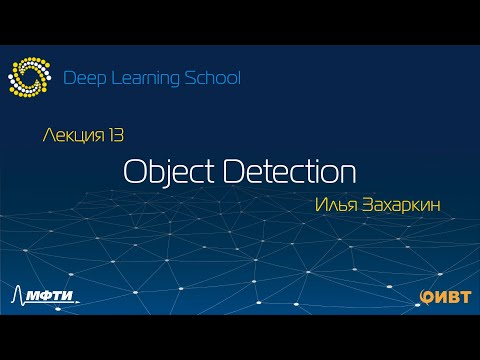

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('ewkSI2cuyoQ')

Основными датасетами сейчас считаются [Googe Open Images V5](https://storage.googleapis.com/openimages/web/index.html) и [Microsoft Common Objects in Conext (MS COCO)](http://cocodataset.org/#detection-2019).

Основная метрика -- Average Precision, которая есть просто подсчет верно покрывающих объекты боксов. Но есть нюансы (см. видео выше с 16:40).

Основные сети для детектирования: FasterRCNN, MaskRCNN, YOLOv3. Мы подробнее рассмотрим Faster-RCNN и MaskRCNN.

**FasterRCNN** состоит из четырех частей: (1)Backbone, (2)RPN, (3)RoI-Pooling и (4)последние слои предсказания классов.

Важные термины:  

*Backbone* -- сеть для предсказания фич (например, ResNet50, или EfficientNet)    
*RoI* -- "Region of Interest"  
*RPN* -- "Region (of Interest) Proposal Network"   
*RoI-Pooling* -- "Region of Interest Pooling"     
*Anchor box* -- заранее заданный bounding box определенных размеров (обычно их для каждой "ячейки" от 3 до 9)

<a href="https://ibb.co/hYHjTcr"><img src="https://i.ibb.co/NTpPGrf/det2.png" alt="det2" border="0" width=700></a>

Пример всех 9-ти anchor боксов для картинки 800х600:

 <img src="https://miro.medium.com/max/1404/1*IS_9HnkfDdF00nID6xxF_A.png" width=500 />

Forward pass картинки через FasterRCNN, описанный в [оригинальной статье](https://arxiv.org/pdf/1506.01497.pdf):   

(картинка из [прекрасного блог-поста](https://medium.com/@smallfishbigsea/faster-r-cnn-explained-864d4fb7e3f8))

<img src="https://miro.medium.com/max/1084/1*wwKCoG-VtBycFeACBES4nA.jpeg" width=350 />

 В самом начале берутся размеры входной картинки, по ним считаются размеры anchor box'ов. Потом картинка проходит через Backbone (обычную CNN, например, ResNet50), и далее через RPN (тоже CNN, но маленькая -- 2-3 сверточных слоя), которая выдаёт **уточнения координат** изначально сгенерированных для каждой ячейки anchor боксов и **вероятность нахождения какаого-либо объекта внутри этих боксов**. Далее из полученных боксов выбрасываются те, у которых вероятность объекта внутри меньше, чем у перекрывающихся с ними, но более уверенных боксов (non-max suppression), и получаем на выходе RPN нужный набор хороших боксов. Далее они подаются в **последние слои FasterRCNN**, чтобы еще больше **уточнить координаты боксов** и предсказать **точный класс объекта внутри каждого бокса**.

Пример работы RoI-Pooling (гифка [отсюда)](https://blog.deepsense.ai/region-of-interest-pooling-explained/):

<img src="https://cdn-sv1.deepsense.ai/wp-content/uploads/2017/02/roi_pooling-1.gif" width=600/>

Для **MaskRCNN** весь процесс абсолютно такой же, но сеть в конце помимо боксов предсказывает еще и маски, то есть ей на вход кроме размеченных прямоугольнкиов нужны еще размеченные точные маски объектов. Кроме этого сеть отличается еще тем, что вместо RoI-Pooling делается RoI-Align (более корректная процедура приведения RoI к единому размеру).

<a href="https://ibb.co/7CMP5rD"><img src="https://i.ibb.co/DWchywF/det4.png" alt="det4" border="0" width=700 /></a>

Если хочется подробнее про остальные архитектуры -- [милости прошу под кат](https://habr.com/ru/company/mipt/blog/458190), а для более продвинутых -- прочитать [современную статью-обзор области детекции на момент августа 2019 года](https://arxiv.org/abs/1809.02165v4) (кстати, картинки архитектур сетей взяты именно из неё).

### Практика

(на основе [официального туториала](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html))

Нам повезло!  

В 2019 году Facebook выпустил модуль для `torchvision`, в которй уже добавлены модели для детектирования и сегментации. Теперь не нужно искать по гитхабу -- достаточно воспользоваться встроенными моделями 

<img src="https://memepedia.ru/wp-content/uploads/2017/05/мем-великий-гэтсби-оригинал.jpg" width=300 />

Загрузим FasterRCNN:

In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [2]:
!wget https://image.shutterstock.com/image-photo/group-people-260nw-602783837.jpg test.jpg
!mv group-people-260nw-602783837.jpg test.jpg
!ls

--2020-04-16 07:41:45--  https://image.shutterstock.com/image-photo/group-people-260nw-602783837.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 23.204.65.39
Connecting to image.shutterstock.com (image.shutterstock.com)|23.204.65.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48609 (47K) [image/jpeg]
Saving to: ‘group-people-260nw-602783837.jpg’

group-people-260nw- 100%[===================>]  47.47K  --.-KB/s    in 0.03s   

Last-modified header invalid -- time-stamp ignored.
2020-04-16 07:41:46 (1.59 MB/s) - ‘group-people-260nw-602783837.jpg’ saved [48609/48609]

--2020-04-16 07:41:46--  http://test.jpg/
Resolving test.jpg (test.jpg)... failed: Name or service not known.
wget: unable to resolve host address ‘test.jpg’
FINISHED --2020-04-16 07:41:46--
Total wall clock time: 0.4s
Downloaded: 1 files, 47K in 0.03s (1.59 MB/s)
sample_data  test.jpg


In [0]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

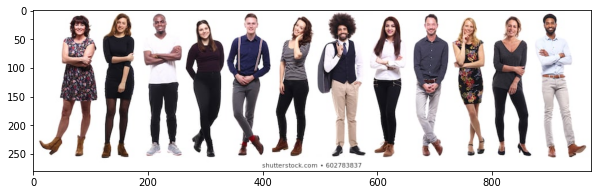

In [39]:
img_path = './test.jpg'
img = cv2.imread(img_path)[:,:,::-1]
fig = plt.figure(figsize=(10,5))
plt.imshow(img);

In [40]:
 # img = img[None]
 img.shape

(280, 974, 3)

In [53]:
img_tensor = torch.tensor(img.astype('float32')/255)
img_tensor = img_tensor[None]
img_tensor[None].size()

torch.Size([1, 1, 280, 974, 3])

In [0]:
img_tensor = img_tensor.permute(0,3,1,2)

In [55]:
model.eval()
predictions = model(img_tensor.cuda())
predictions

[{'boxes': tensor([[ 14.3158,   8.5602, 115.0791, 253.4381],
          [337.6098,   6.8511, 413.7230, 252.0428],
          [589.7033,  10.0958, 650.2061, 254.9260],
          [267.3442,  17.3030, 333.6946, 255.5824],
          [193.6680,   8.1309, 260.7060, 253.6028],
          [422.2102,  11.4213, 487.8574, 251.0169],
          [120.9018,   8.2388, 180.7693, 253.7675],
          [731.1128,  14.4665, 791.8784, 251.6598],
          [499.1318,   9.7717, 578.4976, 256.2612],
          [801.2465,  11.2990, 867.4915, 254.3067],
          [874.3609,   4.9784, 962.2171, 258.6137],
          [664.0148,   9.2175, 726.6874, 254.3811],
          [541.6831,  56.8325, 548.5520,  76.6581],
          [352.5662,  44.4072, 400.7342, 113.8593],
          [529.5683,  55.9454, 542.2265,  80.2307],
          [355.6402,  46.0096, 400.2527, 117.5899],
          [534.0168,   9.3423, 794.2750, 258.2900],
          [222.7824,   9.0249, 468.1794, 259.5898],
          [683.7505, 119.4585, 702.8557, 128.5563],
   

In [73]:
# boxes = predictions[0]['boxes']
# # print(boxes)
# boxes = boxes.cpu().detach().numpy()
CONF_TRESH = 0.5
predictions[0]['scores'][predictions[0]['labels'] == 1] > CONF_TRESH

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False],
       device='cuda:0')

In [64]:
predictions[0]['boxes'][predictions[0]['labels'] == 1]

tensor([[ 14.3158,   8.5602, 115.0791, 253.4381],
        [337.6098,   6.8511, 413.7230, 252.0428],
        [589.7033,  10.0958, 650.2061, 254.9260],
        [267.3442,  17.3030, 333.6946, 255.5824],
        [193.6680,   8.1309, 260.7060, 253.6028],
        [422.2102,  11.4213, 487.8574, 251.0169],
        [120.9018,   8.2388, 180.7693, 253.7675],
        [731.1128,  14.4665, 791.8784, 251.6598],
        [499.1318,   9.7717, 578.4976, 256.2612],
        [801.2465,  11.2990, 867.4915, 254.3067],
        [874.3609,   4.9784, 962.2171, 258.6137],
        [664.0148,   9.2175, 726.6874, 254.3811],
        [534.0168,   9.3423, 794.2750, 258.2900],
        [222.7824,   9.0249, 468.1794, 259.5898],
        [362.2652,   3.2601, 447.2777, 252.1919],
        [137.7130,   6.6376, 227.7212, 256.5672],
        [690.1954,   4.3016, 780.4852, 260.3157],
        [449.4164,  10.7034, 689.9044, 258.4150],
        [682.2075,  12.4843, 920.0244, 256.6456]], device='cuda:0',
       grad_fn=<IndexBackward>)

In [0]:
def plot_preds(numpy_img, predictions):
  CONF_TRESH = 0.7
  boxes = predictions['boxes'][predictions['labels'] == 1]\
    [predictions['scores'][predictions['labels'] == 1] > CONF_TRESH]
  boxes = boxes.cpu().detach().numpy()
  for box in boxes:
    numpy_img = cv2.rectangle(numpy_img, (box[0], box[1]), (box[2], box[3]), 255, 3)
  return numpy_img.get()

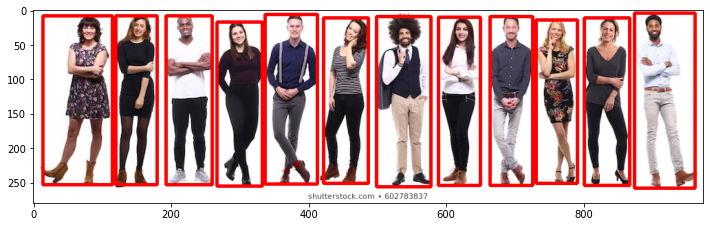

In [79]:
box_img = plot_preds(img, predictions[0])
plt.figure(figsize = (12,7))
plt.imshow(box_img.astype('uint'))

Можем и вовсе собрать свой FasterRCNN с нуля:

In [0]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## Сегментация

### Теория

Общая постановка задачи сегментации -- дана картинка, хотим **попиксельно** выделить на ней интересующие нас объекты (получить их маски).

<img src="https://sergioskar.github.io/assets/img/posts/semseg.jpg" width=650 />

Однако есть 3 более конкретных типа задач сегментации:
1. Семантическая сегментация
2. Instance-сегментация
3. Паноптическая сегментация

Выше пример семантической -- **каждому пикселю картинки присваиваем определенный класс**.

Ниже пример Instance-сегментации -- **выделяем масками только интересующие нас объекты** (то есть не трогаем остальные пиксели, в отличие от семантической).

<img src="https://ashwanikhemani.github.io/img/task_overview.png" width=650 />

Паноптическая сегментация -- "всё вместе":

<img src="https://miro.medium.com/max/2626/1*OelVuv2thUGAj_400WfseQ.png" width=650 />

Общая идея сетей для сегментации -- использовать слои **развертки**. То есть если раньше мы все время понижали размерность входной картинки, то сейчас после этого понижения нам нужно ее обратно повысить, чтобы получить маски на уровне изображения:    


<img src="https://miro.medium.com/max/3486/0*jIBAjzSynvcV-lvO.png" />

Выше показан пример архитектуры нейросети **Fully-Convolutional Network**, или **FCN**. Она действительно столь проста: сначала сворачиваем картинку в фича-вектор с помощью сверток и пулингов, а потом делаем развертку обратно из этого фича-вектора в тензор той же размерности, что и исходное изображение.

**Важно**: в случае **семантической сегментации** у выходного тензора **количество каналов равно количеству классов**, которые мы предсказываем. Так, если какой-то канал соответствует классу **K**, то в каждом **пикселе** этого канала посчитано число, обозначающее **вероятность нахождения объекта  класса K в этом пикселе**.

Пример: хотим попиксельно выделить на обычной RGB-картинке размера (300,300,3) классы "корова" (0), "дом" (1), "земля" (2), "небо" (3). Нейросеть будет выдавать тензор (300,300,4), где 4 -- количество классов, и в канале (:,:,0) в пикселе (i,j) будет вероятность принадлежности этого пикселя к классу "корова", в канале (:,:,1) в пикселе (i,j) будет вероятность принадлежности этого пикселя к классу "дом" и т.д.

В случае **instance-сегментации** сеть, как и в задаче детекции, выдает набор объектов, однако помимо их боксов (можно и без них) сеть выдает точные маски этих объектов.

#### Архитектуры

Помимо **FCN** в задаче сегментации часто используют еще такие сети, как **U-Net** и **DeepLabV3**. 

Идея **U-Net** в том, чтобы во время развертки (upsamling'а) фича-вектора обратно в картинку передавать (конкатенировать) признаки с ранних слоев на более поздние слои, чтобы они могли точнее воспроизвести детали. Схема:

<img src="https://olaralex.com/assets/images/20190705/unet.png" width=700/>

[Отличное объяснение сетей в задаче сегментации от Артура](https://www.youtube.com/watch?v=OWK8VlgJM4I&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=22)

Идея **DeepLabV3** в том, чтобы использовать Atrous Convolutions, известные больше как DilatedConvolutions (картинка отсюда):

<img src="https://miro.medium.com/max/790/0*eGRy1Ydrts4Nibsh.gif" width=400 />

После dilated сверток авторы делают Atrous Spatial Pyramid Pooling, что есть по сути просто конкатенация признаков, полученных от нескольких типов dilation'а:

<img src="https://miro.medium.com/max/1792/1*nuEBRSqMoTXJVkxG5Uts3w.png" width=700 />

### Практика

In [1]:
from torchvision import models

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval().cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


2020-04-16 15:07:25 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


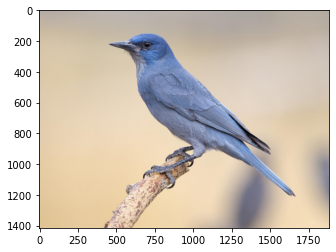

In [42]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import cv2

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

In [34]:
# img_path = './bird.png'
# img_1 = cv2.imread(img_path)[:,:,::-1]
# fcn.eval()
# img_tensor = torch.tensor(img.astype('float32')).cuda().permute(2,0,1)/255.
# predictions = fcn(img_tensor[None])
# predictions
# img_1 = Image.open(img_path)
print(type(img))
import torchvision.transforms as T

trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0).cuda()

out = fcn(inp)['out']
print(out.shape)
import numpy as np
om = torch.argmax(out.squeeze(), dim =0).detach().cpu().numpy()
print(om.shape)
print(np.unique(om))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
torch.Size([1, 21, 224, 224])
(224, 224)
[0 3]


In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

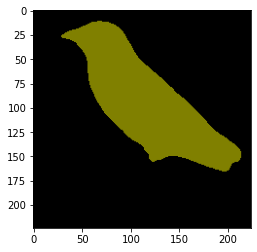

In [36]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [0]:
def segment(model, img_path):
  img = Image.open(img_path)
  trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).cuda()

  out = model(inp)['out']
  print(out.shape)
  import numpy as np
  om = torch.argmax(out.squeeze(), dim =0).detach().cpu().numpy()
  return om

In [61]:
!wget -nv https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg -O horse.png
segment(fcn, './horse.png')


https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg:
2020-04-16 15:20:42 ERROR 503: Service Temporarily Unavailable.


AttributeError: ignored

In [55]:
# DeepLabV3
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval().cuda()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


torch.Size([1, 21, 224, 224])


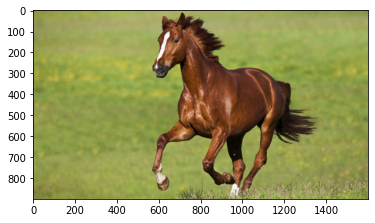

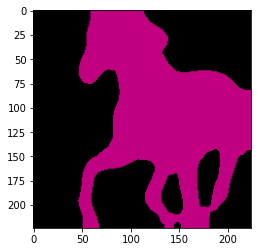

In [56]:
om = segment(dlab, './horse.png')
img = Image.open('./horse.png')
plt.imshow(img); plt.show()
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

## [Detectron2](https://github.com/facebookresearch/detectron2)

Таким образом, чтобы обучить модель для детекции/сегментации/оценки точек, можно:
1. Написать свой цикл обучения на PyTorch. , то етьс напрямую через PyTorch и torchvision. [Подробный разбор как обучить модель в torchvision](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
2. Использовать [Catalyst](https://github.com/catalyst-team/catalyst), где есть  [готовый туториал для задачи сегментации (см. README)](https://github.com/catalyst-team/catalyst/blob/master/examples/notebooks/segmentation-tutorial.ipynb). Все, что нужно сделать -- поменять модель и данные. Имея модель и данные -- нужно только написать правильную обёртку для класса `Dataset`.
3. Использовать [Detectron2](https://github.com/facebookresearch/detectron2). Достаточно ознакомиться с [туториалом из README](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5), и обученная модель у вас в руках 💪

Бонус:

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [58]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotFoundError: Requested device not found


## Резюме:
1. Познакомились с EfficientNet
2. Научились пользоваться Catalyst
3. Погрузились в задачу детектирования и ее архитектуры: FasterRCNN, MaskRCNN и YOLOv3
4. Погрузились в задачу сегментации: узнали типы задач сегментации, рассмотрели архитектуры FCN, UNet и DeepLabV3
5. Научились пользоваться Detectron2 

## Полезные ссылки:
* [Статья Хабр (часть 1)](https://habr.com/ru/company/mipt/blog/450732/) 
* [Статья Хабр (часть 2)](https://habr.com/ru/company/mipt/blog/458190/)